In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from flows import *

## Importing data

In [154]:
# Reading data
with open("../data/gaussian_ssm_data1.txt", "r") as f:
    lines = f.readlines()
    y = [float(i) for i in lines[1].split(',')[1:]]
    x = [float(i) for i in lines[0].split(',')[1:]]

y = torch.tensor([y])[:,-3:]  # only the last values

In [155]:
y

tensor([[-2.3522, -1.6513,  1.1819]])

In [98]:
def create_flow(y,n_layers=5):
    dim = y.size(1)
    normal = distributions.MultivariateNormal(
        torch.zeros(dim), 
        torch.eye(dim)
    )
    flow = RealNVP(dim, n_layers, normal)
    return flow

In [99]:
def log_mu(x):
    log_prob = distributions.Normal(0,1).log_prob(x)
    return log_prob

def log_f(x,x_):
    log_prob = distributions.Normal(0.95*x_, 1).log_prob(x)
    return log_prob

def log_g(y,x):
    log_prob = distributions.Normal(x,1).log_prob(y)
    return log_prob

def log_p(x, y):
    Y = torch.tensor(x.size(0) * list(y[0])).reshape(x.size())
    log_prob = log_mu(x[:,0])
    log_prob += sum([log_f(x[:,i],x[:,i-1]) for i in range(1,Y.size(1))]) 
    log_prob += sum([log_g(Y[:,i],x[:,i]) for i in range(Y.size(1))])
    return log_prob

def loss(flow, y, S=100):
    dim = y.size(0)
    u = distributions.MultivariateNormal(torch.zeros(dim),torch.eye(dim)).sample((S,))
    x, log_det_J = flow.forward(u)
    # log_prob = log_p(x,y)
    return - log_p(x,y).mean(axis=0) - log_det_J.mean()

In [124]:
def batch(size, data):
    '''
    Select a batch of the data.
    '''
    N = data.shape[0]
    rand = np.random.permutation(N)
    selected_lines = rand[-size:]
    return data[selected_lines]
    
def opt_flow(flow, data, lr=1e-4, nIter=500, S=100, verbose=True):
    '''
    Optimize the flow to sample from the distribution
    that originated the data.
    Returns the flow with optimized parameters.
    '''
    optimizer = torch.optim.Adam(
        [p for p in flow.parameters() if p.requires_grad == True], 
        lr=lr
    )
    history = []
    for t in range(nIter+1):    
        cur_batch = batch(100, data.numpy()).astype(np.float32)
        
        loss_ = loss(flow, torch.from_numpy(cur_batch),S) #-flow.log_prob(torch.from_numpy(cur_batch)).mean()
        history.append(loss_.detach())

        optimizer.zero_grad()
        loss_.backward(retain_graph=True)
        optimizer.step()

        if t % 50 == 0 and verbose:
            print('iter %s:' % t, 'loss = %.3f' % loss_)
    return flow, history

In [156]:
flow = create_flow(y, n_layers=2)
flow, history = opt_flow(flow, y, lr=1e-4, nIter=1000, S=500)

iter 0: loss = 12.452
iter 50: loss = 10.055
iter 100: loss = 8.754
iter 150: loss = 7.931
iter 200: loss = 7.064
iter 250: loss = 6.135
iter 300: loss = 5.303
iter 350: loss = 4.758
iter 400: loss = 4.443
iter 450: loss = 4.166
iter 500: loss = 3.998
iter 550: loss = 3.823
iter 600: loss = 3.672
iter 650: loss = 3.447
iter 700: loss = 3.459
iter 750: loss = 3.416
iter 800: loss = 3.215
iter 850: loss = 3.227
iter 900: loss = 3.235
iter 950: loss = 2.961
iter 1000: loss = 2.932


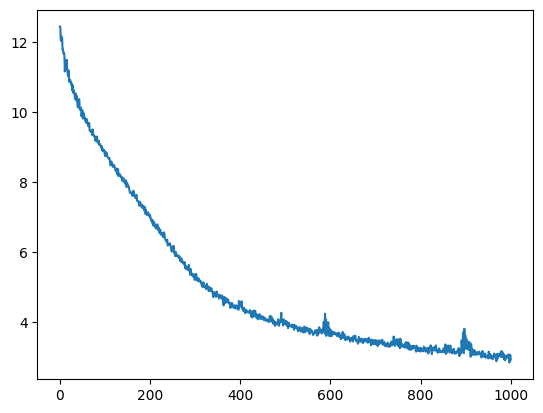

In [157]:
plt.plot(history)

In [177]:
q = flow.log_prob(y)
# y.size()
q.exp()

tensor([9.2186e-05], grad_fn=<ExpBackward0>)

In [163]:
x_samples = flow.sample(1000)
x_hat = x_samples.mean(dim=0)
sigma_x = x_samples.std(dim=0)
x_hat, sigma_x

/home/amanda/Desktop/Estudos/jupyterlab_env/lib/python3.10/site-packages/torch/_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(tensor([-1.3082, 19.4404,  0.0757], grad_fn=<MeanBackward1>),
 tensor([ 6.5432, 51.8961,  5.1957], grad_fn=<StdBackward0>))

In [164]:
y[0].numpy()

array([-2.3522077, -1.6512734,  1.1818644], dtype=float32)

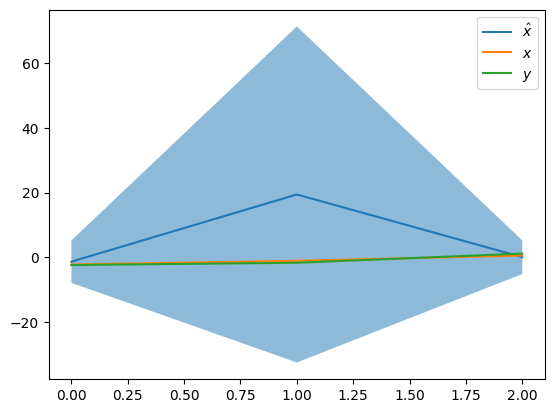

In [170]:
plt.plot(x_hat.detach().numpy(),label=r'$\hat{x}$')
plt.plot(x[98:],label=r'$x$')
plt.plot(y[0].numpy(),label=r'$y$')
plt.fill_between([0,1,2],(x_hat-sigma_x).detach().numpy(), (x_hat+sigma_x).detach().numpy(),alpha=0.5)
plt.legend()

$$
\textrm{min} \ D_{\textrm{KL}} (q || p)
$$

In [2]:
distributions.Normal(0,1).log_prob(torch.tensor([-1])).exp()

tensor([0.2420])

In [4]:
dim = 3
S =10
u = distributions.MultivariateNormal(torch.zeros(dim),torch.eye(dim)).sample((S,))
u

tensor([[ 0.4182,  3.0684, -0.8637],
        [-1.0563,  0.2103,  0.5244],
        [-2.0437, -0.0140,  1.8706],
        [-1.9473, -1.4571, -1.8068],
        [ 1.2324, -0.1293,  1.3022],
        [-2.3904,  0.6876,  0.7951],
        [ 1.7324, -0.6839, -0.7307],
        [-1.9729, -0.8839,  0.6290],
        [-1.6524,  0.5554, -0.5932],
        [ 0.6890,  0.2754,  0.2717]])

In [5]:
normal = distributions.MultivariateNormal(
    torch.zeros(3), 
    torch.eye(3)
)
flow = RealNVP(dim=3, n_layers=5, base_dist=normal)

In [8]:
a,b = flow.forward(u)
b

tensor([-0.1044, -0.1086, -0.5232, -0.4004, -0.1474, -0.3640, -0.0846, -0.4007,
        -0.0895,  0.1348], grad_fn=<AddBackward0>)

In [17]:
a.mean(axis=0)

tensor([-0.4769,  0.1767,  0.3573], grad_fn=<MeanBackward1>)

In [56]:
y = [1.2, 3.1, 1.0]
n=a.size(0)
Y = torch.tensor(n*y).reshape(n,3)
# Y
sum([Y[:,i] + a[:,i] for i in range(3)])
Y[:,2] + a[:,2]

tensor([ 0.0931,  1.7946,  3.4663, -0.8488,  2.7547,  2.1338,  0.3405,  1.9714,
         0.3946,  1.4731], grad_fn=<AddBackward0>)

In [78]:
loss(flow,torch.tensor(y)).exp()

tensor(2.6500e-07, grad_fn=<ExpBackward0>)

In [ ]:
def batch(size, data):
    '''
    Select a batch of the data.
    '''
    N = data.shape[0]
    rand = np.random.permutation(N)
    selected_lines = rand[-size:]
    return data[selected_lines,:]

def opt_flow(flow, data, lr=1e-4, nIter=500, verbose=True):
    '''
    Optimize the flow to sample from the distribution
    that originated the data.
    Returns the flow with optimized parameters.
    '''
    optimizer = torch.optim.Adam(
        [p for p in flow.parameters() if p.requires_grad == True], 
        lr=lr
    )
    for t in range(nIter+1):    
        cur_batch = batch(100, data).astype(np.float32)
        
        loss = -flow.log_prob(torch.from_numpy(cur_batch)).mean()

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if t % 50 == 0 and verbose:
            print('iter %s:' % t, 'loss = %.3f' % loss)
    return flow